# Deconvolving the Mixing Matrix

The goal of this notebook is showcase different ways in which masking can be taken into account when performing 2-point statistics on partial sky maps.

We consider four different methods which we can classify along two axis:
- Is the effect forward modelled in the theory or removed in the data?
- Are we working in Fourier or real space?

The four methods are:
- **Forward method** (Fourier / Forward): In this method we multiply the theory full-sky $C_\ell$ by the mixing matrix.
- **Master method** (Fourier / Forward & Invert): In this method we first multiply the theory full-sky $C_\ell$ by the mixing matrix. Then, we bin the resulting $C_\ell$. Finally, we multiply by the binned inverse mixing matrix.
- **Direct inversion** (Fourier / Invert): In this method we multiply the data by the inverse mixing matrix and bin the resulting $C_\ell$.
- **Polspice**: (Real / Invert): In this method we transform the $C_\ell$ to real-space angular correlation functions and divide them by the mask angular correlation function. This step has to be done carefully to account for the mixing between E and B modes. Finally we transform back to $C_\ell$.


## Dependencies

In [1]:
import heracles
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from heracles.twopoint import mixing_matrices
from heracles.result import Result

## Data Maps

In [2]:
from heracles.healpy import HealpixMapper
from heracles.fields import Positions, Shears, Visibility, Weights

nside = 512
lmax = 600
nbins = 7

In [3]:
data_maps = heracles.read_maps("example_data/example-data_maps.fits")
mapper = HealpixMapper(nside=nside, lmax=lmax)
fields = {
    "POS": Positions(mapper, mask="VIS"),
    "SHE": Shears(mapper, mask="WHT"),
    "VIS": Visibility(mapper),
    "WHT": Weights(mapper),
}
mask_mapper = HealpixMapper(nside=2 * nside, lmax=2 * lmax)
mask_fields = {
    "POS": Positions(mapper, mask="VIS"),
    "SHE": Shears(mapper, mask="WHT"),
    "VIS": Visibility(mapper),
    "WHT": Weights(mapper),
}

In [4]:
data_maps = heracles.read_maps("example_data/example-data_maps.fits")
for key in list(data_maps.keys()):
    f, i = key
    if i <= nbins:
        _map = data_maps[key]
        meta = _map.dtype.metadata
        new_map = hp.ud_grade(_map, nside)
        heracles.update_metadata(
            new_map,
            nside=nside,
            lmax=lmax,
            bias=meta["bias"],
            fsky=meta["fsky"],
            spin=meta["spin"],
        )
        data_maps[key] = new_map
    else:
        data_maps.pop(key)

# load the FITS mask
vis_map = hp.read_map("example_data/vmap.fits.gz")
vis_map[vis_map == hp.UNSEEN] = 0.0
vis_map = hp.ud_grade(vis_map, nside)
heracles.update_metadata(
    vis_map,
    nside=nside,
    lmax=lmax,
    bias=0.0,
    fsky=meta["fsky"],
    spin=0,
)
vis_maps = {}
for key in list(data_maps.keys()):
    f, i = key
    if f == "POS":
        f = "VIS"
    if f == "SHE":
        f = "WHT"
    key = (f, i)
    vis_maps[key] = vis_map

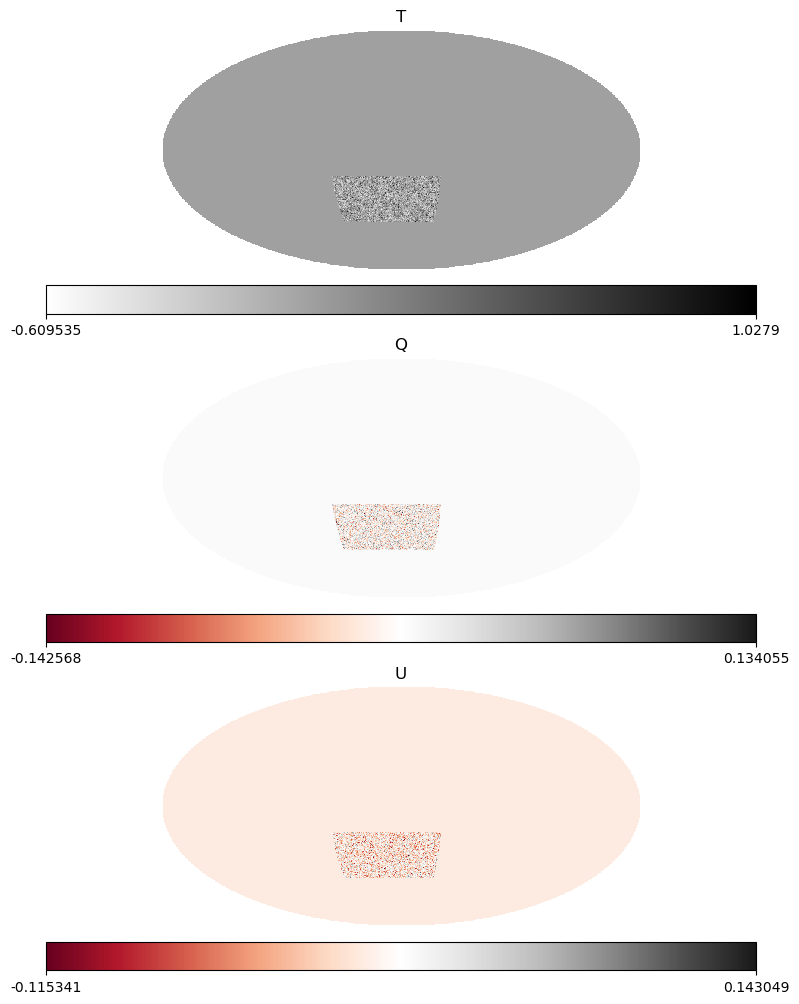

In [5]:
fig, ax = plt.subplots(3, figsize=(20, 10))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(data_maps[("POS", 1)], cmap="binary", title="T", hold=True)
# hp.visufunc.projplot(thetas[:200], phis[:200], 'ro')
plt.sca(ax[1])
hp.mollview(data_maps[("SHE", 1)][0], cmap="RdGy", title="Q", hold=True)
plt.sca(ax[2])
hp.mollview(data_maps[("SHE", 1)][1], cmap="RdGy", title="U", hold=True)
plt.show()

In [6]:
alms = heracles.transform(fields, data_maps)
cls = heracles.angular_power_spectra(alms)
for key in cls.keys():
    r = cls[key].array
    *_, nl = np.atleast_2d(r).shape
    ell = np.arange(nl)
    cls[key] = Result(r, axis=cls[key].axis, ell=ell)

In [7]:
mask_alms = heracles.transform(mask_fields, vis_maps)
mask_cls = heracles.angular_power_spectra(mask_alms)

In [8]:
cls

{('POS', 'POS', 1, 1): Result(axis=(0,)), ('POS', 'SHE', 1, 1): Result(axis=(1,)), ('POS', 'POS', 1, 2): Result(axis=(0,)), ('POS', 'SHE', 1, 2): Result(axis=(1,)), ('POS', 'POS', 1, 3): Result(axis=(0,)), ('POS', 'SHE', 1, 3): Result(axis=(1,)), ('POS', 'POS', 1, 4): Result(axis=(0,)), ('POS', 'SHE', 1, 4): Result(axis=(1,)), ('POS', 'POS', 1, 5): Result(axis=(0,)), ('POS', 'SHE', 1, 5): Result(axis=(1,)), ('POS', 'POS', 1, 6): Result(axis=(0,)), ('POS', 'SHE', 1, 6): Result(axis=(1,)), ('SHE', 'SHE', 1, 1): Result(axis=(2,)), ('POS', 'SHE', 2, 1): Result(axis=(1,)), ('SHE', 'SHE', 1, 2): Result(axis=(2,)), ('POS', 'SHE', 3, 1): Result(axis=(1,)), ('SHE', 'SHE', 1, 3): Result(axis=(2,)), ('POS', 'SHE', 4, 1): Result(axis=(1,)), ('SHE', 'SHE', 1, 4): Result(axis=(2,)), ('POS', 'SHE', 5, 1): Result(axis=(1,)), ('SHE', 'SHE', 1, 5): Result(axis=(2,)), ('POS', 'SHE', 6, 1): Result(axis=(1,)), ('SHE', 'SHE', 1, 6): Result(axis=(2,)), ('POS', 'POS', 2, 2): Result(axis=(0,)), ('POS', 'SHE', 

In [9]:
from heracles.notebook import Progress

with Progress("mixmats") as progress:
    mms = mixing_matrices(
        fields,
        mask_cls,
        l1max=lmax,
        l2max=2 * lmax,
        l3max=2 * lmax + lmax,
        progress=progress,
    )

VBox()

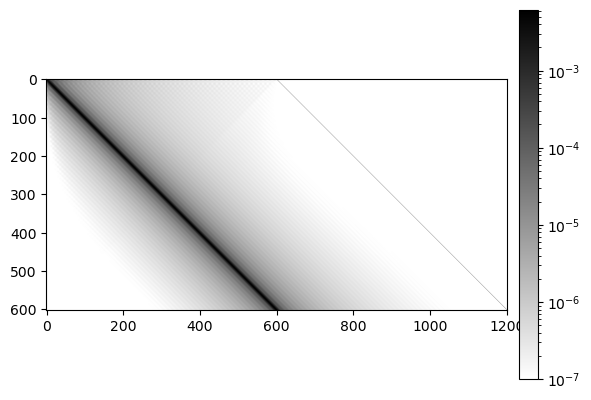

In [10]:
plt.imshow(
    mms["SHE", "SHE", 2, 2][0], cmap="binary", norm=mpl.colors.LogNorm(vmin=1e-7)
)
plt.colorbar(pad=0.025, fraction=0.0465)
plt.show()

## Theory

In [11]:
import camb
from camb.sources import SplinedSourceWindow

In [12]:
# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h, omch2=Oc * h**2, ombh2=Ob * h**2, NonLinear=camb.model.NonLinear_both
)
pars.Want_CMB = False
pars.min_l = 1
pars.set_for_lmax(2 * lmax, lens_potential_accuracy=1);

In [13]:
with np.load("nz.npz") as npz:
    z, nz = npz["z"], npz["nz"]

In [14]:
sources = []
for i, nz_i in enumerate(nz):
    sources += [
        SplinedSourceWindow(source_type="counts", z=z, W=nz_i),
        SplinedSourceWindow(source_type="lensing", z=z, W=nz_i),
    ]
pars.SourceWindows = sources

In [15]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=2 * lmax, raw_cl=True)

In [16]:
ell = np.arange(lmax + 1)
ell2 = np.arange(2 * lmax + 1)
fl = -np.sqrt((ell2 + 2) * (ell2 + 1) * ell2 * (ell2 - 1))
fl /= np.clip(ell2 * (ell2 + 1), 1, None)

In [17]:
theory = {}
for i in range(1, nbins):
    for j in range(i, nbins):
        # all mixing matrix combinations
        theory["POS", "POS", i, j] = camb_cls[f"W{2 * i - 1}xW{2 * j - 1}"]
        theory["POS", "SHE", i, j] = np.stack(
            [
                fl * camb_cls[f"W{2 * i - 1}xW{2 * j}"],
                np.zeros_like(ell2),
            ]
        )
        theory["POS", "SHE", j, i] = np.stack(
            [
                fl * camb_cls[f"W{2 * i}xW{2 * j - 1}"],
                np.zeros_like(ell2),
            ]
        )
        theory["SHE", "SHE", i, j] = np.stack(
            [
                [fl**2 * camb_cls[f"W{2 * i}xW{2 * j}"], np.zeros_like(ell2)],
                [np.zeros_like(ell2), np.zeros_like(ell2)],
            ]
        )

for key in theory.keys():
    c = cls[key]
    print(key, c.array.shape, c.axis, theory[key].shape, theory[key].dtype)
    theory[key] = Result(theory[key], axis=c.axis, ell=ell2)

('POS', 'POS', 1, 1) (601,) (0,) (1201,) float64
('POS', 'SHE', 1, 1) (2, 601) (1,) (2, 1201) float64
('SHE', 'SHE', 1, 1) (2, 2, 601) (2,) (2, 2, 1201) float64
('POS', 'POS', 1, 2) (601,) (0,) (1201,) float64
('POS', 'SHE', 1, 2) (2, 601) (1,) (2, 1201) float64
('POS', 'SHE', 2, 1) (2, 601) (1,) (2, 1201) float64
('SHE', 'SHE', 1, 2) (2, 2, 601) (2,) (2, 2, 1201) float64
('POS', 'POS', 1, 3) (601,) (0,) (1201,) float64
('POS', 'SHE', 1, 3) (2, 601) (1,) (2, 1201) float64
('POS', 'SHE', 3, 1) (2, 601) (1,) (2, 1201) float64
('SHE', 'SHE', 1, 3) (2, 2, 601) (2,) (2, 2, 1201) float64
('POS', 'POS', 1, 4) (601,) (0,) (1201,) float64
('POS', 'SHE', 1, 4) (2, 601) (1,) (2, 1201) float64
('POS', 'SHE', 4, 1) (2, 601) (1,) (2, 1201) float64
('SHE', 'SHE', 1, 4) (2, 2, 601) (2,) (2, 2, 1201) float64
('POS', 'POS', 1, 5) (601,) (0,) (1201,) float64
('POS', 'SHE', 1, 5) (2, 601) (1,) (2, 1201) float64
('POS', 'SHE', 5, 1) (2, 601) (1,) (2, 1201) float64
('SHE', 'SHE', 1, 5) (2, 2, 601) (2,) (2, 

## Binning

In [18]:
nlbins = 10
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)

## Plotting

In [19]:
def plot_clustering(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins)+1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls["POS", "POS", i, j].ell[1:],
                cls["POS", "POS", i, j][1:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "POS", i, j].ell[1:],
                theory["POS", "POS", i, j][1:],
                c="C0",
                lw=1.0,
                zorder=4.0,
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-2e-7, 2e-4)

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig


def plot_shear(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins)+1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls["SHE", "SHE", i, j].ell[2:],
                cls["SHE", "SHE", i, j][0, 0, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["SHE", "SHE", i, j].ell[2:],
                theory["SHE", "SHE", i, j][0, 0, 2:],
                c="C0",
                lw=1.0,
                zorder=4.0,
            )
            ax[j - 1, i - 1].plot(
                cls["SHE", "SHE", i, j].ell[2:],
                cls["SHE", "SHE", i, j][1, 1, 2:],
                c="C1",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["SHE", "SHE", i, j].ell[2:],
                theory["SHE", "SHE", i, j][1, 1, 2:],
                c="C1",
                lw=1.0,
                zorder=2.0,
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-3e-10, 5e-7)

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig


def plot_clusteringxshear(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins)+1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, nbins):
            ax[j - 1, i - 1].plot(
                cls["POS", "SHE", i, j].ell[2:],
                cls["POS", "SHE", i, j][0, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "SHE", i, j].ell[2:],
                theory["POS", "SHE", i, j][0, 2:],
                c="C0",
                lw=1.0,
                zorder=4.0,
            )
            ax[j - 1, i - 1].plot(
                cls["POS", "SHE", i, j].ell[2:],
                cls["POS", "SHE", i, j][1, 2:],
                c="C1",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "SHE", i, j].ell[2:],
                theory["POS", "SHE", i, j][1, 2:],
                c="C1",
                lw=1.0,
                zorder=2.0,
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-8e-6, 4e-8)

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

    plt.show()

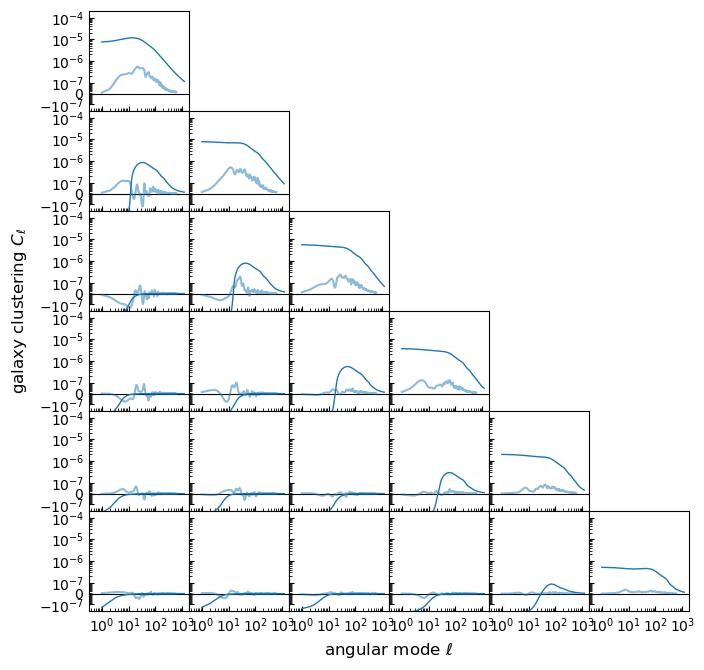

In [20]:
plot_clustering(cls, theory);

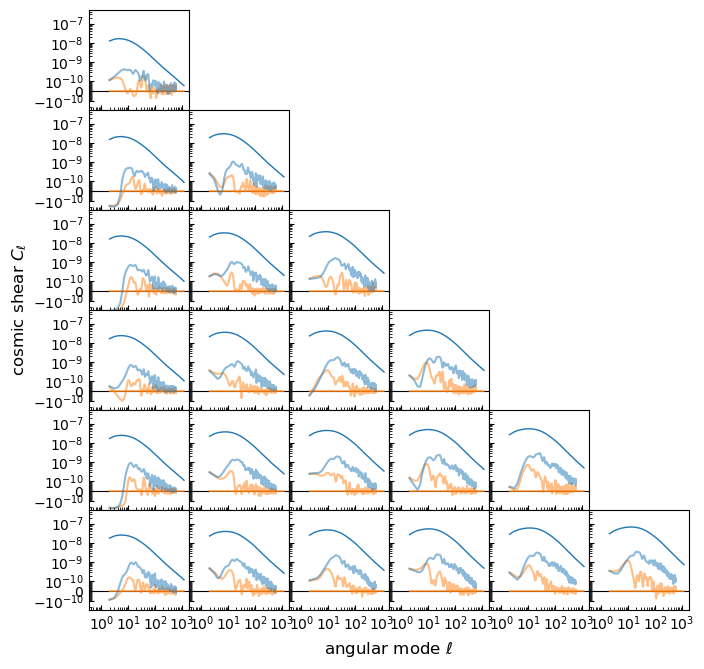

In [21]:
plot_shear(cls, theory);

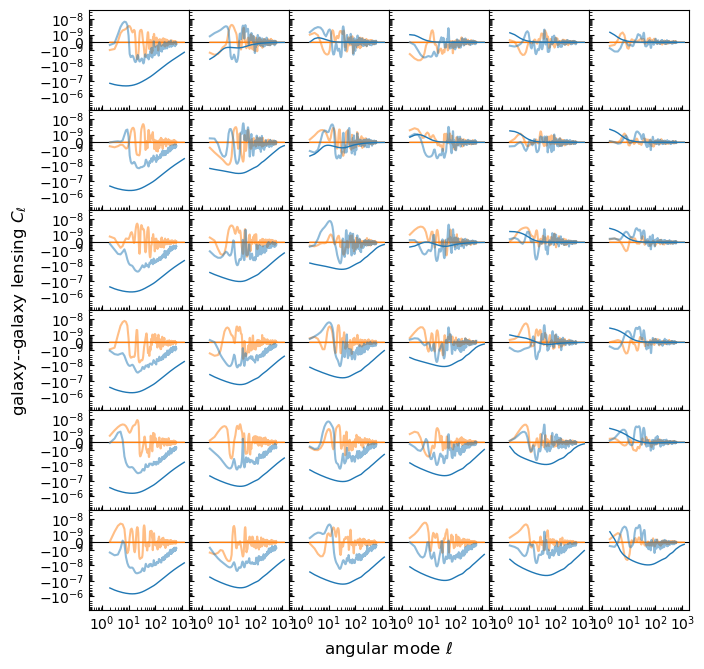

In [22]:
plot_clusteringxshear(cls, theory);

## Forward Model 

In Fourier space, we can relate an observed angular power spectrum $\tilde{C}_\ell$ to a theoretical full-sky angular power spectrum $C_\ell$ through the mixing matrix $M$, a matrix that contains the effect of the mask:
$$ \tilde{C}_\ell = M C_\ell $$

We find better results by considering a non-square square matrix such that the theory $C_\ell$'s are evaluated up to $2\ell_{max}$, where $\ell_{max}$ is the maximum multipole considered for the observed $\tilde{C}_\ell$.

We can modify the previous fudamental relation to express all Fourier space methods by considering a general matrix, A, such that:
$$ A \tilde{C}_\ell = A M C_\ell $$

Becuase we are often interested in the binned angular power spectrum, in the forward method $A = B$, where $B$ is the binning matrix.

To account for the E-B mixing, we compute the parial sky $C_\ell$  as:
$$ \tilde{C}_\ell^{EE} = B(M^{EE} C_\ell^{BB} + M^{BB} C_\ell^{EE}) \\
   \tilde{C}_\ell^{BB} = B(M^{EE} C_\ell^{EE} + M^{BB} C_\ell^{BB}) 
$$

Note that in our case $C_\ell^{BB} = 0$ by definition.

In [23]:
for key in mms.keys():
    print(key, mms[key].shape)

('POS', 'POS', 1, 1) (601, 1201)
('POS', 'SHE', 1, 1) (601, 1201)
('POS', 'POS', 1, 2) (601, 1201)
('POS', 'SHE', 1, 2) (601, 1201)
('POS', 'POS', 1, 3) (601, 1201)
('POS', 'SHE', 1, 3) (601, 1201)
('POS', 'POS', 1, 4) (601, 1201)
('POS', 'SHE', 1, 4) (601, 1201)
('POS', 'POS', 1, 5) (601, 1201)
('POS', 'SHE', 1, 5) (601, 1201)
('POS', 'POS', 1, 6) (601, 1201)
('POS', 'SHE', 1, 6) (601, 1201)
('SHE', 'SHE', 1, 1) (3, 601, 1201)
('POS', 'SHE', 2, 1) (601, 1201)
('SHE', 'SHE', 1, 2) (3, 601, 1201)
('POS', 'SHE', 3, 1) (601, 1201)
('SHE', 'SHE', 1, 3) (3, 601, 1201)
('POS', 'SHE', 4, 1) (601, 1201)
('SHE', 'SHE', 1, 4) (3, 601, 1201)
('POS', 'SHE', 5, 1) (601, 1201)
('SHE', 'SHE', 1, 5) (3, 601, 1201)
('POS', 'SHE', 6, 1) (601, 1201)
('SHE', 'SHE', 1, 6) (3, 601, 1201)
('POS', 'POS', 2, 2) (601, 1201)
('POS', 'SHE', 2, 2) (601, 1201)
('POS', 'POS', 2, 3) (601, 1201)
('POS', 'SHE', 2, 3) (601, 1201)
('POS', 'POS', 2, 4) (601, 1201)
('POS', 'SHE', 2, 4) (601, 1201)
('POS', 'POS', 2, 5) (601

In [24]:
ft = heracles.forwards(theory, mms)

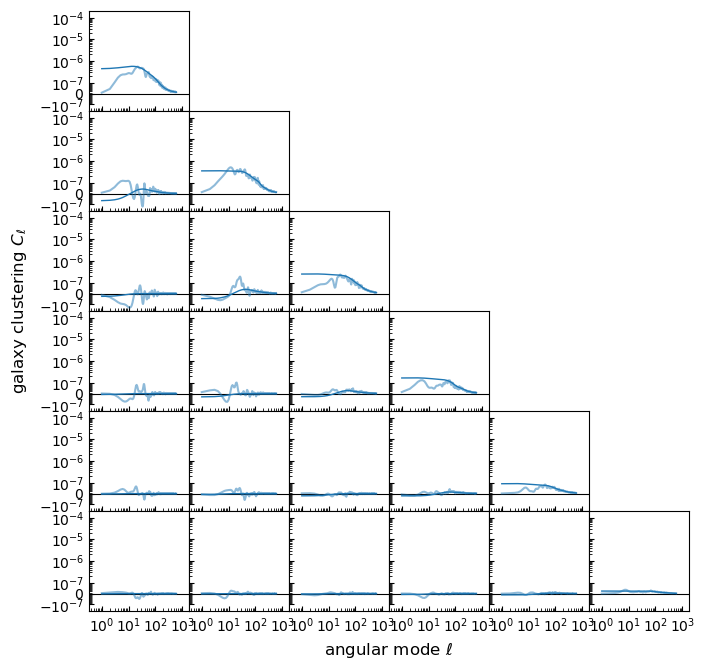

In [25]:
plot_clustering(cls, ft);

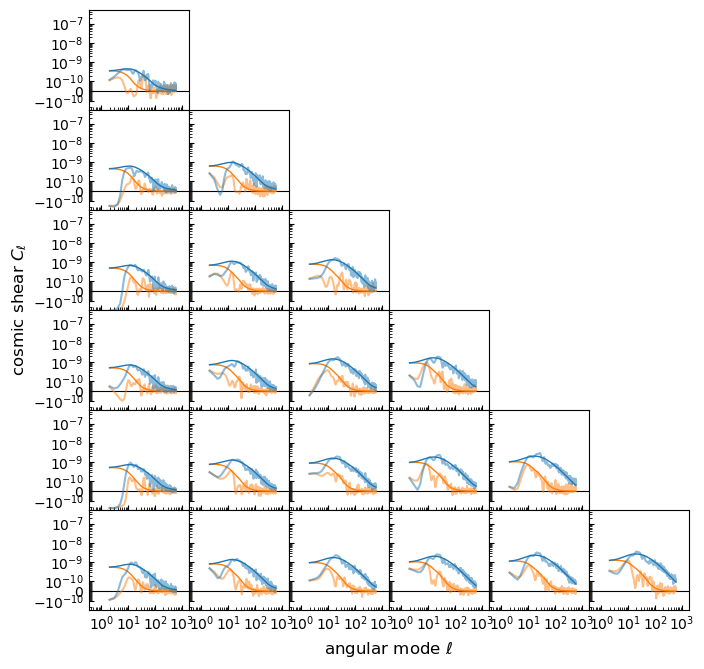

In [26]:
plot_shear(cls, ft);

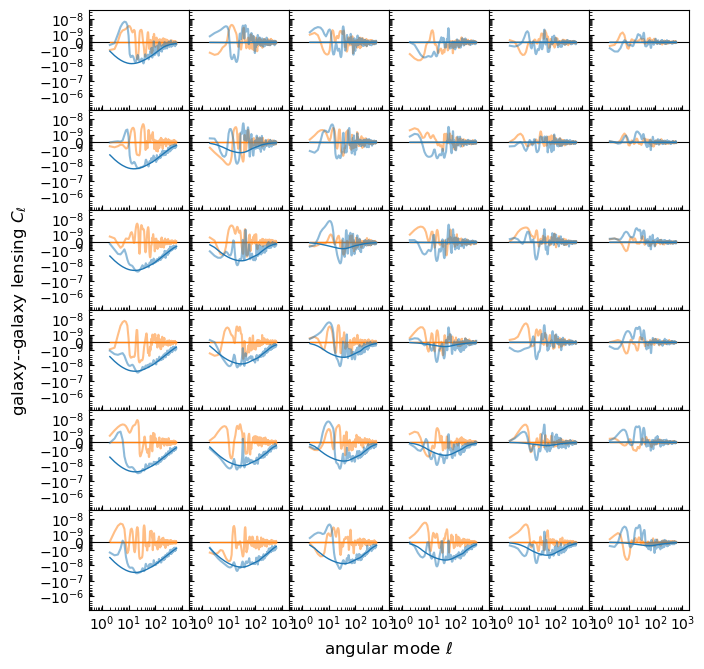

In [27]:
plot_clusteringxshear(cls, ft);

## Direct Inversion

The direct inversion method is equivalent to considering $A = B M^{-1}$.

To account for the E-B mixing, we compute the full sky $C_\ell^{E/B}$  as:
$$  \begin{bmatrix} 
 \langle C_l^{E\!E'} \rangle \\ \langle C_l^{B\!B'} \rangle  \end{bmatrix}
 =
\begin{bmatrix}
   M^{E\!E E'\!E'} & M^{B\!B E'\!E'} \\
   M^{E\!E B'\!B'} & M^{B\!B B'\!B'} 
\end{bmatrix}^{-1}
\begin{bmatrix} 
    \langle \tilde{C}_l^{E\!E'} \rangle \\ \langle \tilde{C}_l^{B\!B'} \rangle 
\end{bmatrix}
$$

In [28]:
inv_cls = heracles.inversion(cls, mms)

In [29]:
inv_cqs = heracles.binned(inv_cls, ledges)

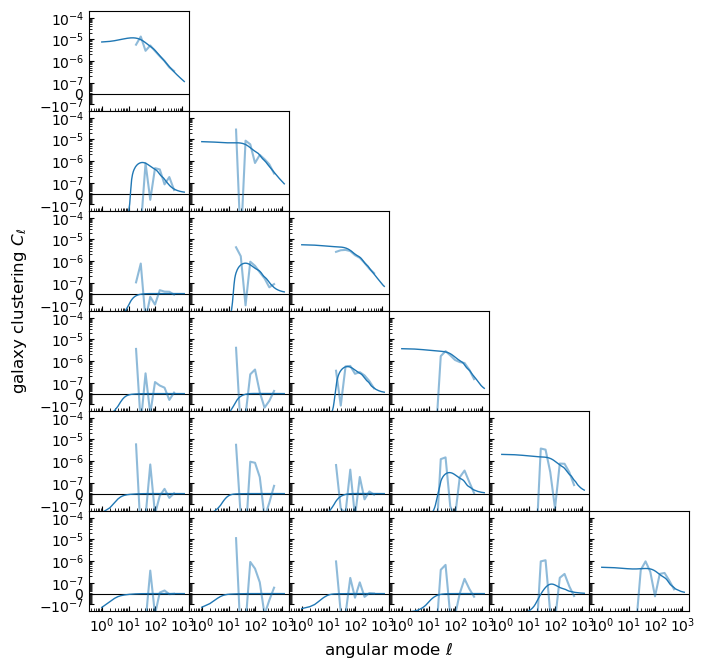

In [30]:
plot_clustering(inv_cqs, theory);

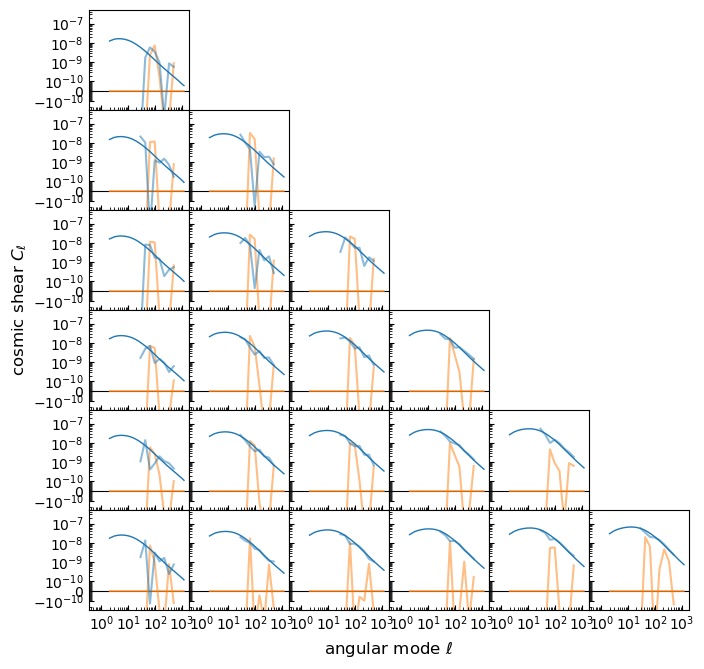

In [31]:
plot_shear(inv_cqs, theory);

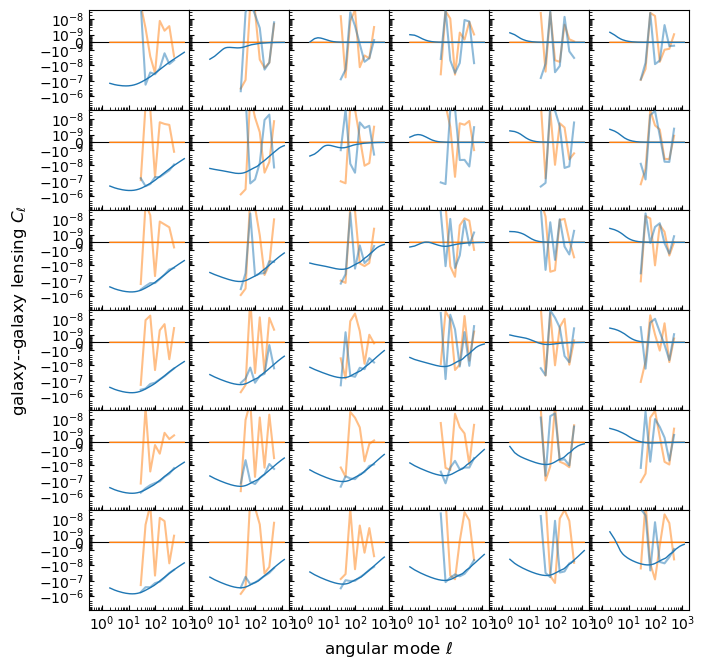

In [32]:
plot_clusteringxshear(inv_cqs, theory);

## Master Model

Similarly, the master method is equivalent to considering $A = (B M B^T)^{-1} B$.
Since the the initial steps of computing the master method $C_\ell$'s are the same as the forward method we reuse the previously computed $C_\ell$'s. However, we still need to apply the inverse binning matrix to get the final $C_\ell$'s.
Because we originally considered a non-square mixing matrix, we first crop the mixing matrix to the size of the data $C_\ell$'s we then bin. This operation is done in one single operation by applying the matrix $B_2$. 

Since the mixing of the E and B modes is already accounted in the first step when multiplying by the mixing matrix, we do not need to consider the mixing when inverting the binned mixing matrix.

In [33]:
master_cqs, master_theory = heracles.master(theory, cls, mms, ledges)

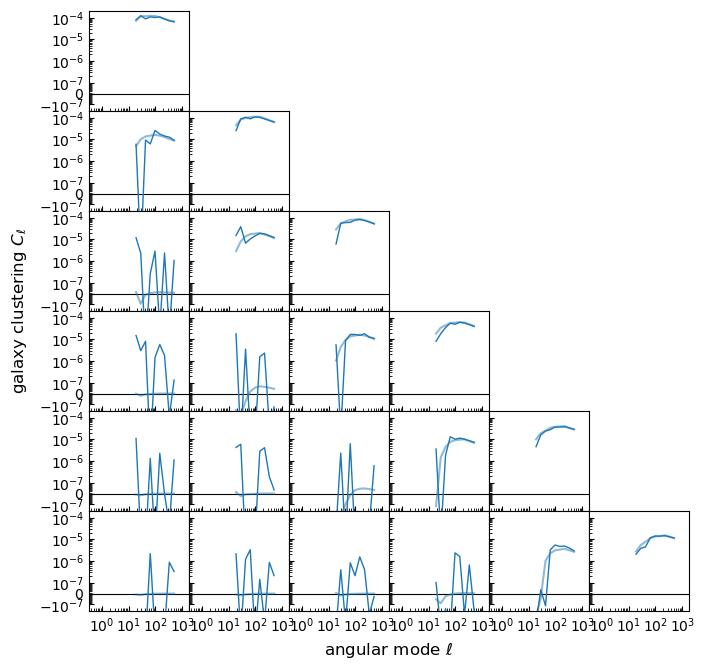

In [34]:
plot_clustering(master_cqs, master_theory);

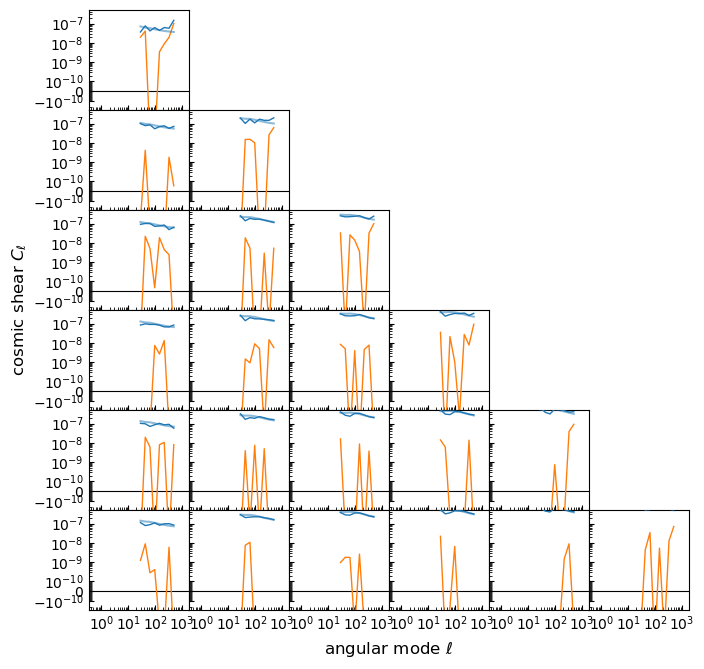

In [35]:
plot_shear(master_cqs, master_theory);

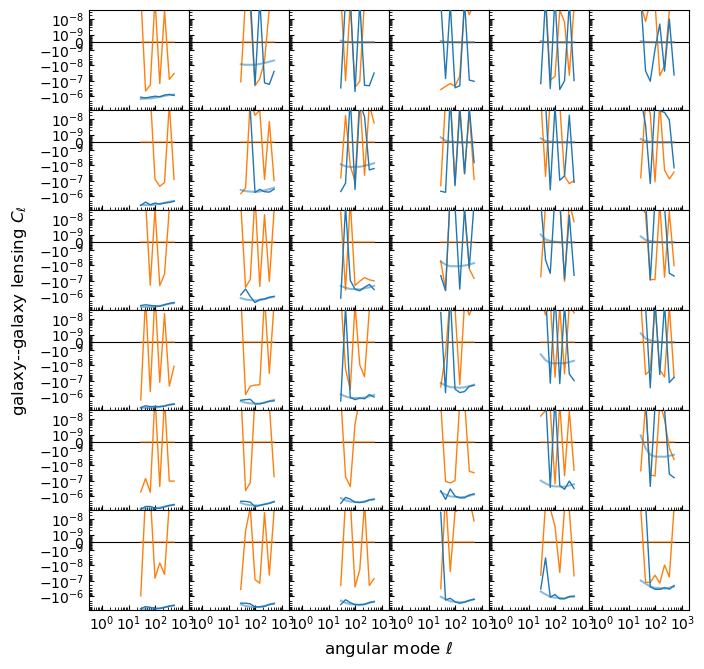

In [36]:
plot_clusteringxshear(master_cqs, master_theory);

## Natural Inversion

In the Polspice method we account for the effect of the mask in real space. 
Let's start laying down some definitions. Given a complex field:
$$ \gamma(n) = (Q \pm i U)(n) = \sum_{l m} (E_{l m} \mp i B_{l m}) _{\mp 2} Y_{l m}(n)  $$
we can define the correlators:
$$ \xi_{+} = \langle \gamma^* \gamma\rangle  \hspace{6pt}\rm{and}\hspace{6pt} \xi_{-} = \langle \gamma \gamma \rangle $$
Then the associated parital sky correlatiors are given by:
$$ \xi_{\pm}(\theta) = \frac{\tilde{\xi}_{\pm}(\theta)}{\xi^{ww'}(\theta)} $$
which we can also express in terms of linear combinations of the measured $E$ and $B$ angular power spectra:
$$  \tilde{\xi}_{\pm}(\theta) = \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta) $$

The PolSpice method undoes the $E-B$ coupling by defining a correlator akin to $\xi_{+}(\theta)$ but with the Wigner matrix of a spin -2 field:
$$
\xi_{\rm dec}(\theta) = \frac{\tilde{\xi}_{\rm dec}(\theta)}{\xi^{ww'}(\theta)} = \nonumber \\ 
= \frac{1}{\xi^{ww'}(\theta)} \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l +  \tilde{C}^{BB}_l) d^l_{2 - 2}(\theta)
$$

Then one can construct a estimator for the full sky angular correlation functions by combining the correlation function and inverting the SWSH transform:
$$
C^{EE}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) + \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$
$$
C^{BB}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) - \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$

In [37]:
nu_d = heracles.PolSpice(cls, mask_cls, patch_hole=True)
nu_dq = heracles.binned(nu_d, ledges)
theory_q = heracles.binned(theory, ledges)

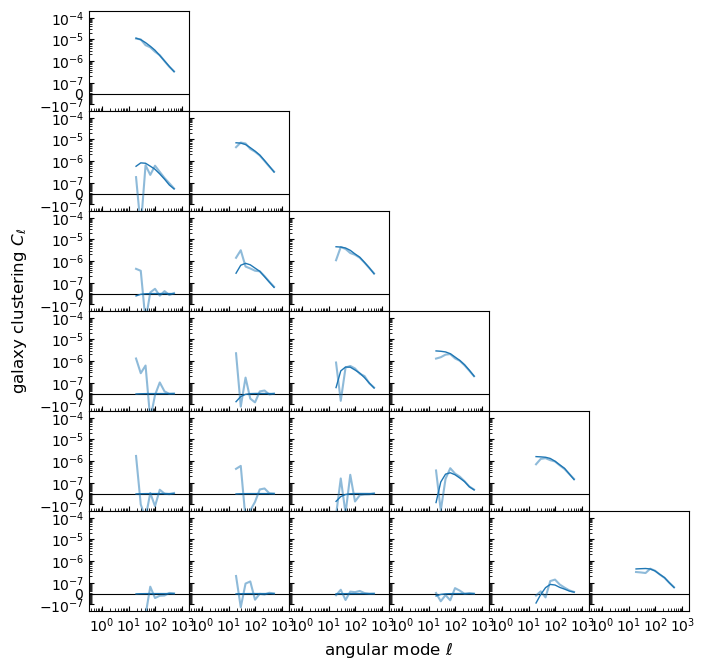

In [38]:
plot_clustering(nu_dq, theory_q);

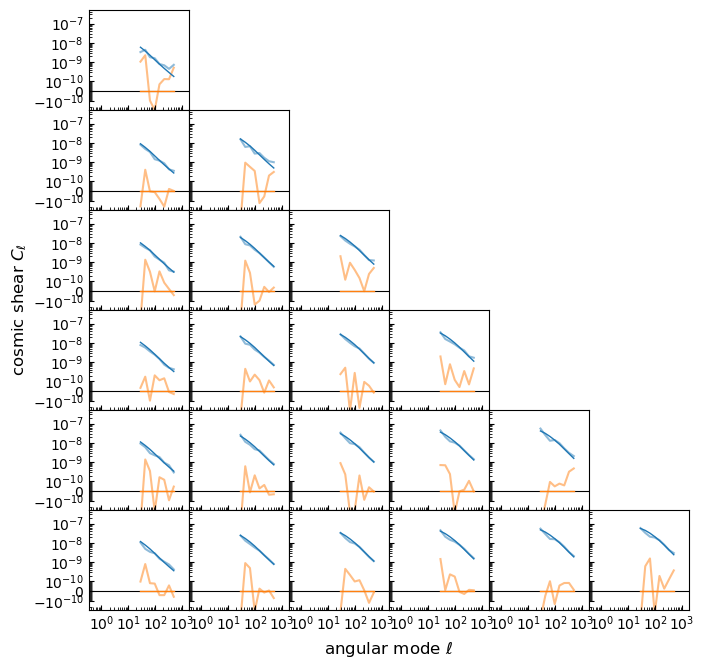

In [39]:
plot_shear(nu_dq, theory_q);

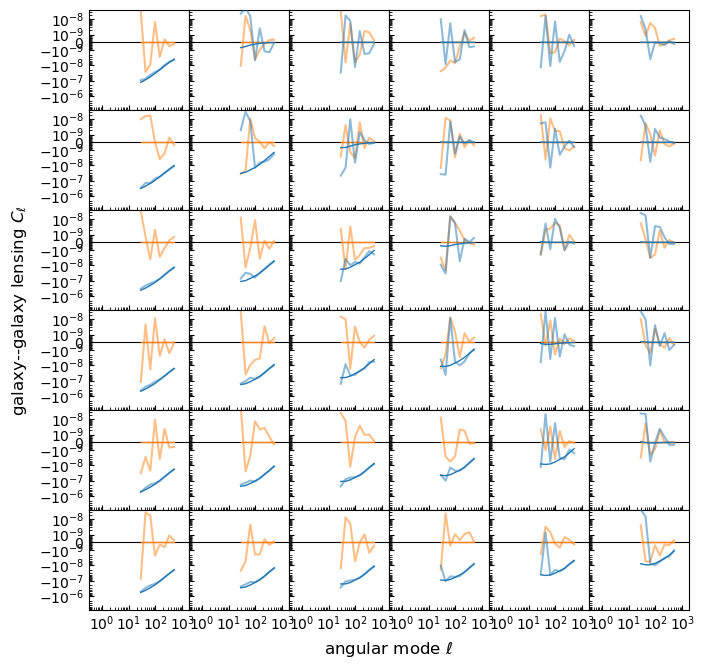

In [40]:
plot_clusteringxshear(nu_dq, theory_q);

## PolSpice 

In [41]:
psp_d = heracles.PolSpice(cls, mask_cls, patch_hole=True, mode="plus")
psp_dq = heracles.binned(psp_d, ledges)
psm_d = heracles.PolSpice(cls, mask_cls, patch_hole=True, mode="minus")
psm_dq = heracles.binned(psm_d, ledges)
theory_q = heracles.binned(theory, ledges)

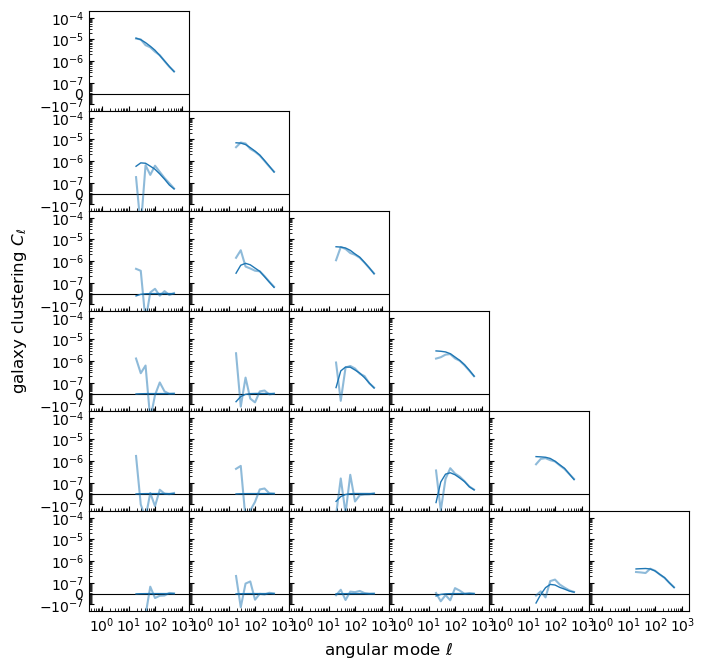

In [42]:
plot_clustering(psp_dq, theory_q);

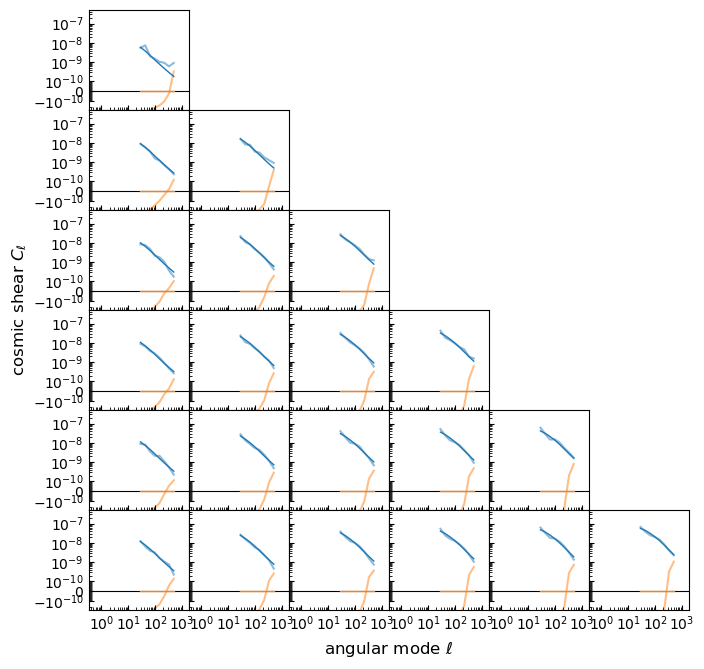

In [43]:
plot_shear(psp_dq, theory_q);

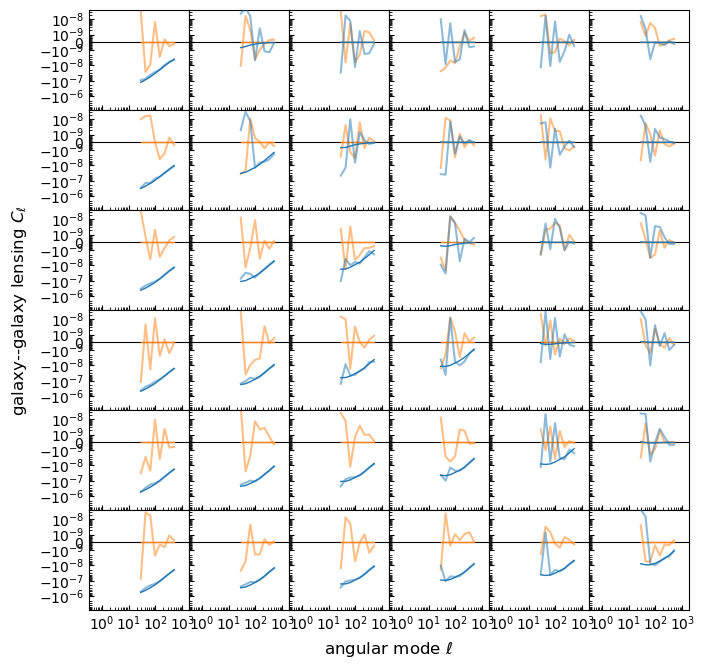

In [44]:
plot_clusteringxshear(psp_dq, theory_q);

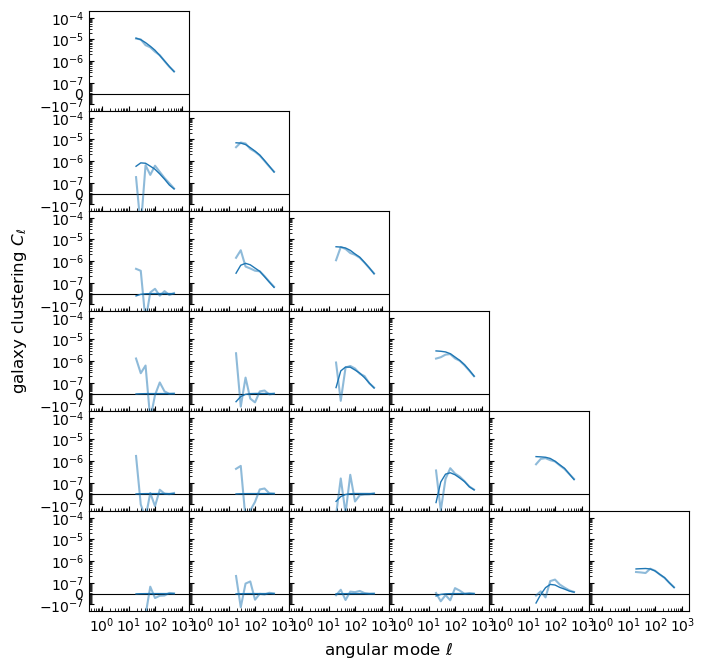

In [45]:
plot_clustering(psm_dq, theory_q);

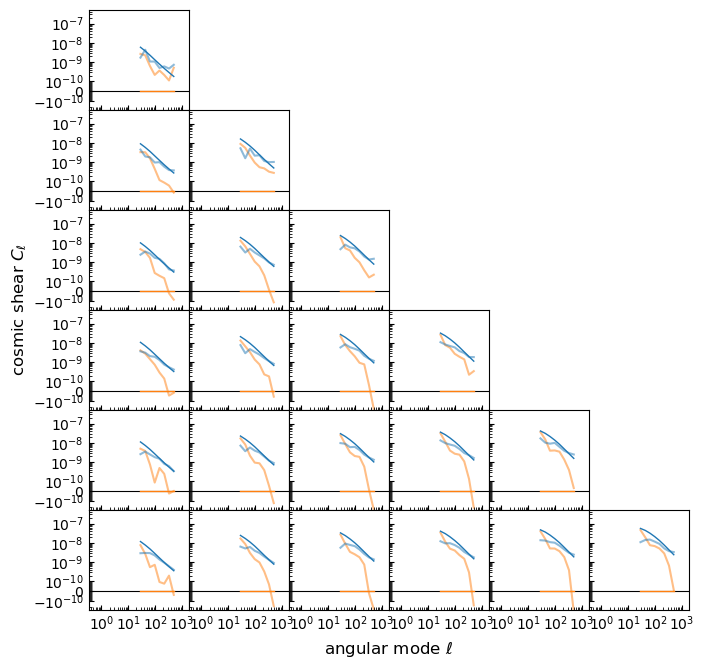

In [46]:
plot_shear(psm_dq, theory_q);

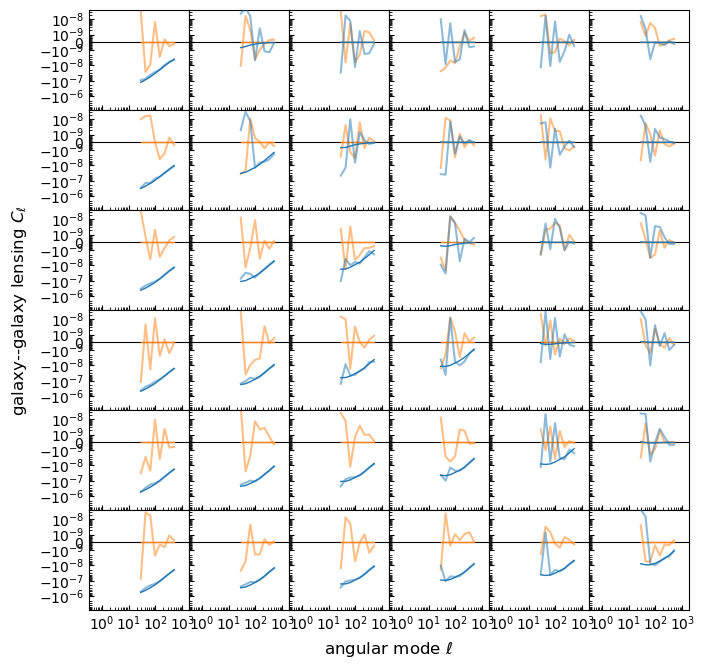

In [47]:
plot_clusteringxshear(psm_dq, theory_q);

In [69]:
def plot_clustering(cls_inv, cls_natural, cls_psp, cls_psm, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = 3 # max(bins)+1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls_inv["POS", "POS", i, j].ell[1:],
                cls_inv["POS", "POS", i, j][1:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="Direct Inversion",
            )
            ax[j - 1, i - 1].plot(
                cls_natural["POS", "POS", i, j].ell[1:],
                cls_natural["POS", "POS", i, j][1:],
                c="C1",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="Natural Inversion",
            )
            ax[j - 1, i - 1].plot(
                cls_psp["POS", "POS", i, j].ell[1:],
                cls_psp["POS", "POS", i, j][1:],
                c="C2",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="PolSpice +",
            )
            ax[j - 1, i - 1].plot(
                cls_psm["POS", "POS", i, j].ell[1:],
                cls_psm["POS", "POS", i, j][1:],
                c="C3",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="PolSpice -",
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "POS", i, j].ell[1:],
                theory["POS", "POS", i, j][1:],
                c="k",
                lw=1.0,
                zorder=4.0,
                label="Theory",
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(10, 2*lmax+1)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-2e-4, 2e-4)
    ax[0, 0].legend(
        loc="upper right",
        fontsize="small",
        frameon=False,
        handlelength=1.5,
        handletextpad=0.5,
        borderpad=0.2,
        labelspacing=0.2,
        borderaxespad=0.2,
        ncol=1,
        columnspacing=0.5,
        bbox_to_anchor=(1.5, 1.0),
    )

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig


def plot_shearE(cls_inv, cls_natural, cls_psp, cls_psm, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = 3 #max(bins)+1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls_inv["SHE", "SHE", i, j].ell[2:],
                cls_inv["SHE", "SHE", i, j][0, 0, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="Direct Inversion",
            )
            ax[j - 1, i - 1].plot(
                cls_natural["SHE", "SHE", i, j].ell[2:],
                cls_natural["SHE", "SHE", i, j][0, 0, 2:],
                c="C1",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="Natural Inversion",
            )
            ax[j - 1, i - 1].plot(
                cls_psp["SHE", "SHE", i, j].ell[2:],
                cls_psp["SHE", "SHE", i, j][0, 0, 2:],
                c="C2",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="PolSpice +",
            )
            ax[j - 1, i - 1].plot(
                cls_psm["SHE", "SHE", i, j].ell[2:],
                cls_psm["SHE", "SHE", i, j][0, 0, 2:],
                c="C3",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="PolSpice -",
            )

            ax[j - 1, i - 1].plot(
                theory["SHE", "SHE", i, j].ell[2:],
                theory["SHE", "SHE", i, j][0, 0, 2:],
                c="k",
                lw=1.0,
                zorder=4.0,
                label="Theory",
            )
            
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(10, 2*lmax+1)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-3e-7, 5e-7)
    ax[0, 0].legend(
        loc="upper right",
        fontsize="small",
        frameon=False,
        handlelength=1.5,
        handletextpad=0.5,
        borderpad=0.2,
        labelspacing=0.2,
        borderaxespad=0.2,
        ncol=1,
        columnspacing=0.5,
        bbox_to_anchor=(1.5, 1.0),
    )

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("cosmic shear E-mode  $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig

def plot_shearB(cls_inv, cls_natural, cls_psp, cls_psm, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = 3 #max(bins)+1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls_inv["SHE", "SHE", i, j].ell[2:],
                cls_inv["SHE", "SHE", i, j][1, 1, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="Direct Inversion",
            )
            ax[j - 1, i - 1].plot(
                cls_natural["SHE", "SHE", i, j].ell[2:],
                cls_natural["SHE", "SHE", i, j][1, 1, 2:],
                c="C1",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="Natural Inversion",
            )
            ax[j - 1, i - 1].plot(
                cls_psp["SHE", "SHE", i, j].ell[2:],
                cls_psp["SHE", "SHE", i, j][1, 1, 2:],
                c="C2",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="PolSpice +",
            )
            ax[j - 1, i - 1].plot(
                cls_psm["SHE", "SHE", i, j].ell[2:],
                cls_psm["SHE", "SHE", i, j][1, 1, 2:],
                c="C3",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
                label="PolSpice -",
            )

            ax[j - 1, i - 1].plot(
                theory["SHE", "SHE", i, j].ell[2:],
                theory["SHE", "SHE", i, j][1, 1, 2:],
                c="k",
                lw=1.0,
                zorder=4.0,
                label="Theory",
            )
            
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(10, 2*lmax+1)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-3e-7, 5e-7)
    ax[0, 0].legend(
        loc="upper right",
        fontsize="small",
        frameon=False,
        handlelength=1.5,
        handletextpad=0.5,
        borderpad=0.2,
        labelspacing=0.2,
        borderaxespad=0.2,
        ncol=1,
        columnspacing=0.5,
        bbox_to_anchor=(1.5, 1.0),
    )

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("cosmic shear B-mode $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig


def plot_clusteringxshear(cls_inv, cls_natural, cls_psp, cls_psm, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins)+1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, nbins):
            ax[j - 1, i - 1].plot(
                cls_inv["POS", "SHE", i, j].ell[2:],
                cls_inv["POS", "SHE", i, j][0, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                cls_inv["POS", "SHE", i, j].ell[2:],
                cls_inv["POS", "SHE", i, j][1, 2:],
                '--',
                c="C0",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                cls_natural["POS", "SHE", i, j].ell[2:],
                cls_natural["POS", "SHE", i, j][0, 2:],
                c="C1",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                cls_natural["POS", "SHE", i, j].ell[2:],
                cls_natural["POS", "SHE", i, j][1, 2:],
                '--',
                c="C1",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                cls_psp["POS", "SHE", i, j].ell[2:],
                cls_psp["POS", "SHE", i, j][0, 2:],
                c="C2",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                cls_psp["POS", "SHE", i, j].ell[2:],
                cls_psp["POS", "SHE", i, j][1, 2:],
                '--',
                c="C2",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                cls_psm["POS", "SHE", i, j].ell[2:],
                cls_psm["POS", "SHE", i, j][0, 2:],
                c="C3",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                cls_psm["POS", "SHE", i, j].ell[2:],
                cls_psm["POS", "SHE", i, j][1, 2:],
                '--',
                c="C3",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "SHE", i, j].ell[2:],
                theory["POS", "SHE", i, j][0, 2:],
                c="k",
                lw=1.0,
                zorder=4.0,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "SHE", i, j].ell[2:],
                theory["POS", "SHE", i, j][1, 2:],
                c="C1",
                lw=1.0,
                zorder=2.0,
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(10, 2*lmax+1)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-8e-6, 4e-8)
    ax[0, 0].legend(
        loc="upper right",
        fontsize="small",
        frameon=False,
        handlelength=1.5,
        handletextpad=0.5,
        borderpad=0.2,
        labelspacing=0.2,
        borderaxespad=0.2,
        ncol=1,
        columnspacing=0.5,
        bbox_to_anchor=(1.0, 1.0),
    )

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

    plt.show()

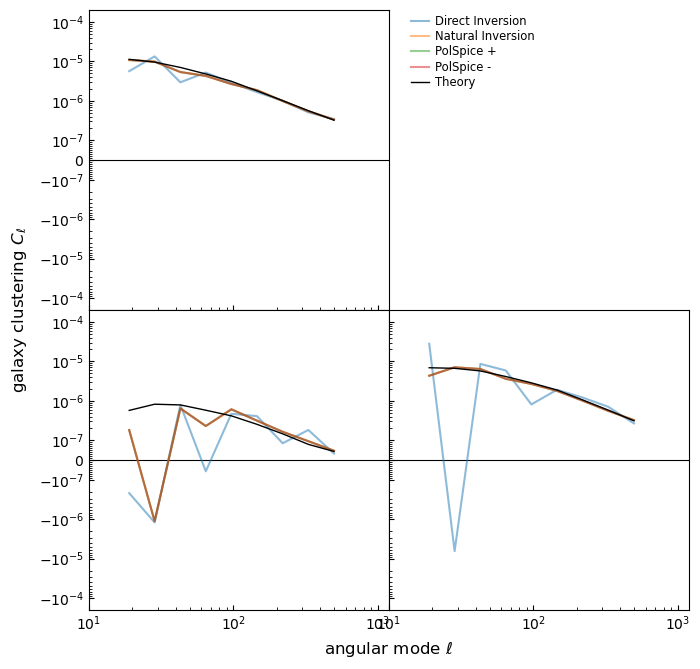

In [70]:
plot_clustering(inv_cqs, nu_dq, psp_dq, psm_dq, theory_q);

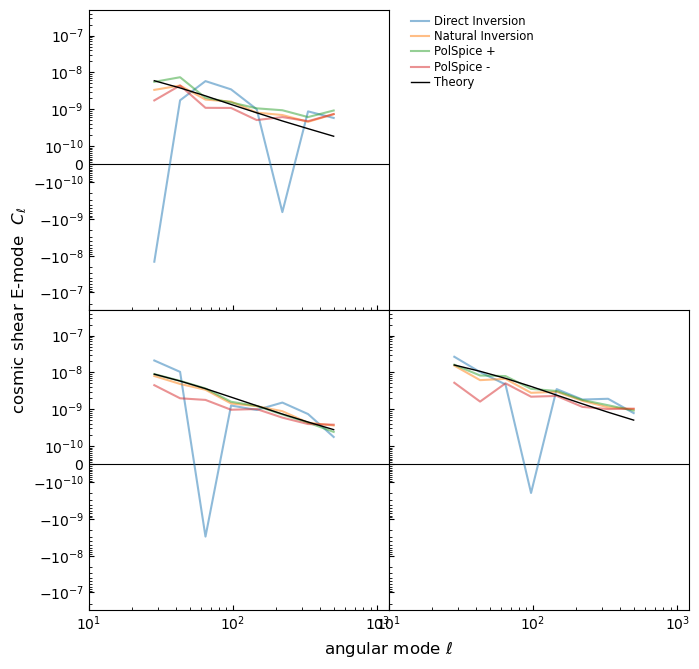

In [71]:
plot_shearE(inv_cqs, nu_dq, psp_dq, psm_dq, theory_q);

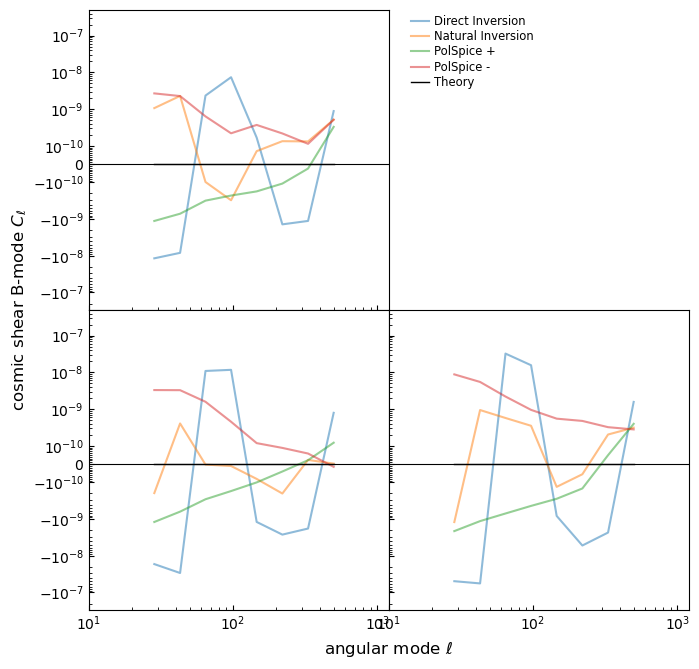

In [72]:
plot_shearB(inv_cqs, nu_dq, psp_dq, psm_dq, theory_q);

/tmp/ipykernel_111631/3121992653.py:387: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0, 0].legend(


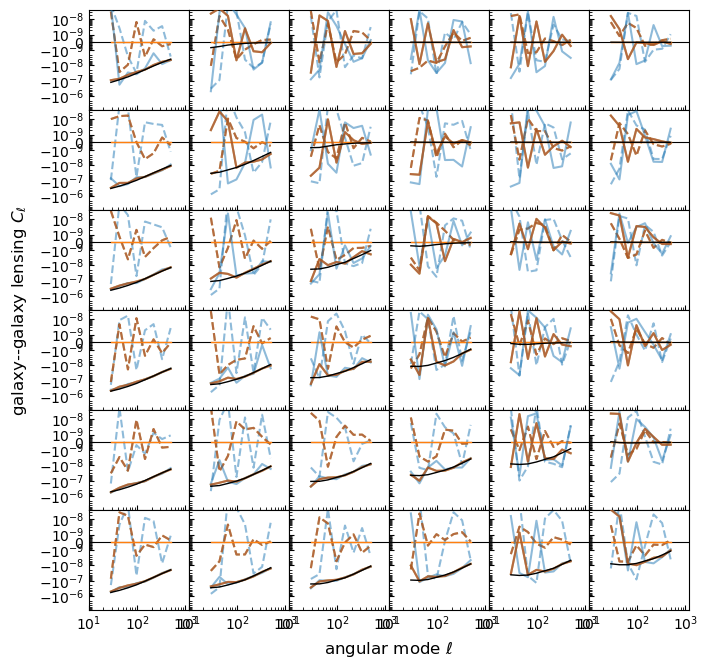

In [52]:
plot_clusteringxshear(inv_cqs, nu_dq, psp_dq, psm_dq, theory_q);